<!--
IRdisplay::display_html(file='code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->
<!--
<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>
-->


**Author**: Adrian Ernesto Radillo  
**Date**: 28 Mar 2019
### LINKS TO MAIN SECTIONS
[Introduction](#intro)  
[Data pre-processing](#preproc)  
[Timing and trials checks](#checks)  
[Accuracy analysis](#acc)  
[Dot count in hemifields](#dotcount)  
[Autocorrelation of choices](#autocorr)  

# Introduction
<a id='intro'></a>
## Notebook's goals

Prepare data for analysis.

## A word on the data for this notebook
The tag for this data is `Pilot 12`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot12.mat).

## Feedback about my own impressions doing the task
- Fixation point still not red but white at start of trial
- sometimes, and involuntary head or eye movement during stimulus presentation changes the perception of the dots (they become lines). I don't know if the eye-tracker will pick up on that, but if it doesn't it is an issue.
- Getting comfy in front of the screen is not so easy to achieve

## Data analysis workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (for this dataset, the branch `psychophys_tests` was used).
  1. A `.mat` data file is outputted (here, `2019_03_27_10_49_topsDataLog.mat`); in addition, I manually copy all the output from the MATLAB console into a text file (here, `consoleDump_2019_03_27_10_49.log`)
  2. I upload important data files to PennBox (location = Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch -- currently `logistic_fits`).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/05d405594b1908ea9854d155617b038ac47356af/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- After verifying that the random seeds allow us perfect reproduction of the dots stimulus, stop dumping DOTS and FRAMES data, that is, only stick to the `FIRA` data.

## Unordered Q&A
**Q:** Does the Quest node behave the same way as the task node with respect to skipped trials?  
**A:** 

**Q:** How many frames are skipped on each trial, and where in the trial do they occur?  
**A:** No frames are skipped (see figure in [this section](#tightFrames))  

**Q:** Plot indep var. as fcn of trial count, to ensure real randomization was implemented by the task algorithm.  
**A:** Things look fine [here](#randIndVar).
    
**Q:** Why [this pattern of errors](#errorsVD) in `(dotsOff-dotsOn) - viewingDuration`?  
**A: Unanswered**  


**Q:** Why [these dots counts](#numDots)?  
**A:** This is because of the way the total number of dots is divided into 3 to allocate them to interleaved frames.  

**Q:** Do subjects display a tendency to repeat the answer from the last trial?  
**A:** Can [autocorrelation](#autocorr) tell us something?  


**Q:** Do subjects use the dot count in each half of the screen to make up their mind at low coherence levels?  
**A:** It doesn't seem so according to [this section](#dotcount).

In [1]:
# load packages 

# Note:
# if one of the packages below is not installed, type, once, in another cell
# install.packages("<package_name>", lib="<path_to_installation_folder>")
# note that if you don't put the lib arg above, it will default to first item in .libPaths()
# ref:https://www.rdocumentation.org/packages/utils/versions/3.5.2/topics/install.packages

# I can't load the conflicted package here :(
# library(conflicted)
# https://github.com/r-lib/conflicted/issues/26

library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
library(gridExtra)      # to use grid.arrange()

source("../R_functions.r") # custom functions

In [2]:
# DEFINE CONSTANTS
# folder/file-specific constants
PILOT_NUMBER <- 12
DATA_FOLDER <- "../../data/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# data-related constants
FIRST_TRIALS_TO_DISCARD <- 1

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [3]:
# load csv files into data.tables
TRIALS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG)
FRAMES <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG)
DOTS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG)

# Data pre-processing
<a id='preproc'></a>
## Summary of `TRIALS` dataset (`*FIRA.csv` file)

In [4]:
# set some variables to "factor"
TRIALS[,`:=`(choice=as.factor(choice), 
            correct=as.logical(correct), # probably a bad idea to have this be a factor variable
            initDirection=as.factor(initDirection),
            endDirection=as.factor(endDirection),
            presenceCP=as.logical(presenceCP))]
# put back in missing values
TRIALS[choice == 'NaN' | correct == 'NaN', `:=`(choice = NA, correct = NA)] 

# display summary for reference
str(TRIALS)

Classes ‘data.table’ and 'data.frame':	256 obs. of  27 variables:
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex     : int  155 126 61 143 196 145 54 22 193 67 ...
 $ trialStart     : num  650761 650767 650770 650775 650779 ...
 $ trialEnd       : num  650767 650770 650775 650779 650782 ...
 $ RT             : num  0.715 0.681 1.004 1.007 0.67 ...
 $ choice         : Factor w/ 3 levels "0","1","NaN": 2 1 1 2 1 2 1 1 2 2 ...
 $ correct        : logi  TRUE TRUE FALSE TRUE TRUE TRUE ...
 $ initDirection  : Factor w/ 2 levels "0","180": 1 2 1 1 2 1 2 2 1 1 ...
 $ endDirection   : Factor w/ 2 levels "0","180": 1 2 1 1 2 1 2 2 1 1 ...
 $ presenceCP     : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ coherence      : num  22 20 18 32 31 29 28 27 25 23 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ probCP         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  6824 7050 

## Summary of `FRAMES` dataset (`*framesInfo.csv` file)

In [5]:
str(FRAMES)

Classes ‘data.table’ and 'data.frame':	4872 obs. of  6 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  650762 650763 650765 650765 650765 ...
 $ onsetFrame   : int  238 338 421 425 426 427 428 429 430 431 ...
 $ swapTime     : num  650762 650763 650765 650765 650765 ...
 $ isTight      : int  0 0 0 0 1 1 1 1 1 1 ...
 $ trialIndex   : int  155 155 155 155 155 155 155 155 155 155 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Summary of `DOTS` dataset (`*dotsPositions.csv` file)

In [6]:
str(DOTS)

Classes ‘data.table’ and 'data.frame':	24588 obs. of  6 variables:
 $ xpos      : num  0.573 0.787 0.879 0.444 0.838 ...
 $ ypos      : num  0.0886 0.0697 0.2138 0.8452 0.9675 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 0 ...
 $ isCoherent: int  1 0 0 0 0 0 0 0 0 0 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 2 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Classify trials
We classify trials as follows:
- `valid` means that the trial is kept in the analysis
- `skipped` means that no answer was recorded (this could be linked to fixation break for instance)
- `bug` means the code itself renders the trial unusable (for instance the 1st trial, because of our timing bug)
- `early` means that an answer was provided before the end of the viewing duration

Currently, I don't control for the fact that a single trial might fall into more than one non-valid category. I just make sure all `valid` trials are indeed valid.

In [7]:
setkey(TRIALS, 'trialStart')
TRIALS[taskID==1, trialInSession:=.I]
TRIALS[taskID==2, trialInSession:=.I]
TRIALS[,`:=`(trialClass='valid')]

In [8]:
TRIALS[is.na(choice), trialClass:='skipped']
# TRIALS[trialInSession <= FIRST_TRIALS_TO_DISCARD, trialClass:='bug']
TRIALS[RT <= 0, trialClass:='early']
TRIALS[,trialClass:=as.factor(trialClass)]

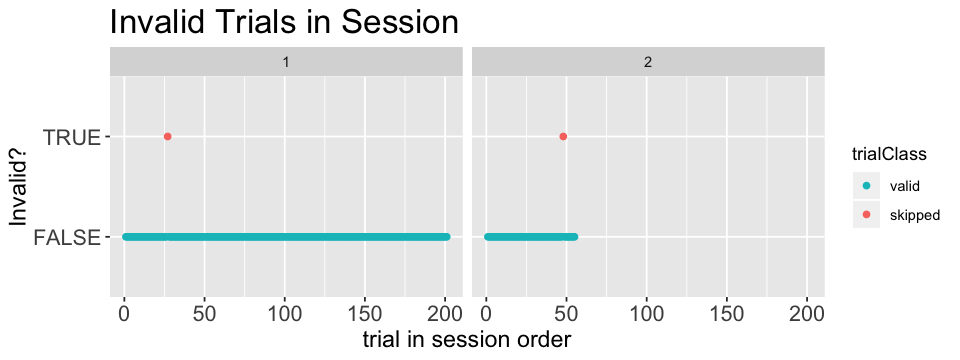

In [9]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=3)

ggplot(TRIALS, aes(x=trialInSession, y=trialClass != 'valid')) + 
    geom_point(aes(col=trialClass)) +
    facet_grid(. ~ taskID) + 
    labs(title="Invalid Trials in Session", x="trial in session order", y="Invalid?") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15,family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT)) + # Y axis text
    guides(colour = guide_legend(reverse=T))

## Match trials across datasets

How many trials were produced in each dataset?

In [10]:
cat('TRIALS',TRIALS[,.N],
   '\nDOTS  ',DOTS[,max(trialCount)],
   '\nFRAMES',max(FRAMES[,.GRP,by=trialIndex])) # can I improve this syntax? 
# nrow is inefficient compared to .N
#the following URL are enlightening
#https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html

TRIALS 256 
DOTS   200 
FRAMES 200

(Note, with the current way in which the DOTS and FRAMES datasets are produced, I have a hard time distinguishing between the two nodes (i.e. `taskID`))

We need to get the trials to match across datasets. 

Let's introduce a `validTrialCount` column in all datasets, with invalid trials flagged `validTrialCount=NA_integer_`.

In [11]:
TRIALS[trialClass == 'valid' & taskID==1, validTrialCount:=.I]
TRIALS[trialClass == 'valid' & taskID==2, validTrialCount:=.I]

In [12]:
TRIALS[trialClass != 'valid', validTrialCount := NA_integer_]

In [13]:
# cat('TRIALS data.table has',
#     nrow(TRIALS[!is.na(validTrialCount),.(validTrialCount)]),
#     'valid trials with min, max values') 
# TRIALS[!is.na(validTrialCount),.(min(validTrialCount),max(validTrialCount))]
cat('TRIALS dataset has a total of',TRIALS[taskID==1,sum(trialClass=='valid')],'valid trials in the Quest node', 
   'and', TRIALS[taskID==2, sum(trialClass=='valid')],'in the task node.')

TRIALS dataset has a total of 200 valid trials in the Quest node and 54 in the task node.

In [14]:
?.N

In [15]:
# to match TRIALS to FRAMES, we use timestamps. 

# add the validTrialCount and taskID cols to FRAMES
FRAMES[,`:=`(validTrialCount=0, taskID=NA_integer_)]
# str(FRAMES)

# NOTE: following for loop is SLOW, but I don't know of a way to speed things up
# TODO: post question online

# loop through rows in FRAMES and set trialCount appropriately
for (numRow in 1:nrow(FRAMES)) {
    frameOnset <- FRAMES[numRow, onsetTime]
    if (length(TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]) == 0) {
        cat('discarding frame from row ',numRow, 'in FRAMES\n')
        FRAMES[numRow, "validTrialCount"] <- NA_integer_
    } else if (length(TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]) > 1) {
        cat('row ',numRow, 'in FRAMES falls in more than one trial!\n')
    } else {
        FRAMES[numRow, "validTrialCount"] <- TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]
        FRAMES[numRow, "taskID"] <- TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,taskID]
    }
}

cat('FRAMES dataset has a total of',FRAMES[taskID==1 & !is.na(validTrialCount), .N, by=validTrialCount][,.N],'valid trials in the Quest node', 
   'and', FRAMES[taskID==2 & !is.na(validTrialCount), .N, by=validTrialCount][,.N],'in the task node.')

discarding frame from row  3534 in FRAMES
discarding frame from row  3535 in FRAMES
discarding frame from row  3536 in FRAMES
discarding frame from row  3537 in FRAMES
discarding frame from row  3538 in FRAMES
discarding frame from row  3539 in FRAMES
discarding frame from row  3540 in FRAMES
discarding frame from row  3541 in FRAMES
discarding frame from row  3542 in FRAMES
discarding frame from row  3543 in FRAMES
discarding frame from row  3544 in FRAMES
discarding frame from row  4872 in FRAMES
FRAMES dataset has a total of 200 valid trials in the Quest node and 54 in the task node.

In [ ]:
# ggplot(FRAMES[!is.na(validTrialCount),.(numFrames=.N),by=validTrialCount], aes(x=validTrialCount, y=numFrames)) + geom_line()
# ggplot(TRIALS[!is.na(validTrialCount),.(VD=dotsOff-dotsOn),by=validTrialCount], aes(x=validTrialCount, y=VD)) + geom_line()

Hurray, we managed to match `FRAMES` and `TRIALS`! Let's deal with the `DOTS` dataset now.

In [16]:
tmp_dt <- TRIALS[!is.na(choice)]
tmp_dt[,trialCount := .I] # the trialCount col is meant to match the trialCount col from DOTS dataset

# uncomment below to perform the checks
# tmp_dt[,.(min(trialCount),max(trialCount))]
# nrow(tmp_dt[,.(trialCount)])
# DOTS[,.(min(trialCount),max(trialCount))]
# nrow(DOTS[,.(.N),by=trialCount])

In [17]:
# let's perform an inner join now
setkey(DOTS, trialCount)
setkey(tmp_dt, trialCount)
DOTS <- DOTS[tmp_dt, nomatch=0]
# str(DOTS)

In [ ]:
# And we are done!
# cat('new DOTS data.table has',
#     nrow(DOTS[!is.na(validTrialCount),.N,by=validTrialCount]),
#     'valid trials with min, max values') 
# DOTS[!is.na(validTrialCount),.(min=min(validTrialCount), max=max(validTrialCount))]

Now the three datasets should perfectly match via the column `validTrialCount`!

In [20]:
cat('Dataset trials',
    '\nTRIALS  ',nrow(TRIALS[!is.na(validTrialCount)]),
    '\nDOTS    ',nrow(DOTS[!is.na(validTrialCount),.N,by=trialCount]),
    '\nFRAMES  ',
    FRAMES[taskID==1 & !is.na(validTrialCount), .N, by=validTrialCount][,.N] +
    FRAMES[taskID==2 & !is.na(validTrialCount), .N, by=validTrialCount][,.N],
    "\n\nIf all of the above match, it's a good sign!")

Dataset trials 
TRIALS   254 
DOTS     200 
FRAMES   254 

If all of the above match, it's a good sign!

I believe that my code doesn't dump DOTS data for the second node.

In [21]:
cat("number of active dots per frame appearing across trials",
    unique(DOTS[!is.na(validTrialCount),.(numDots=sum(isActive)), by=.(validTrialCount,frameIdx)][,numDots])
    ,"\n")

number of active dots per frame appearing across trials 3 


Not all frames have the same number of active dots because of the way the MATLAB code currently assigns the dots to the the frames (see `dotsDrawableDotKinetogram.computeNextFrame()`).

# Timing and trial checks
<a id='checks'></a>
How long did the session last?

In [22]:
cat( round(TRIALS[,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

16.78 min

<!-- this is not so important anymore.
Were some trials presented again after failure? -->

In [ ]:
# print("below are the trial counts corresponding to trials that were presented a second time (lapse)")
# TRIALS[,.(trialIndex, trialCount)][duplicated(TRIALS[,.(trialIndex)])]

- How many trials were produced per combination of factors? **(TODO: any better way of displaying these results?)**

In [ ]:
print("How can I better visualize this?")
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(TRIALS[!is.na(validTrialCount)], indepVarNames)
combFactors

- What were the marginal frequencies? **(TODO:improve visualization)**

In [ ]:
# print("visualization pending")
for (i in 1:length(indepVarNames)) {
  print(getFreq(TRIALS[!is.na(validTrialCount)], indepVarNames[i]))
  cat("\n\n")
}

## Random indep vars.
<a id='randIndVar'></a>
We now plot the independent variables as a function of trial number in the task, to check randomization (at least eye-balling).

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=10)


p1 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=dotsOff - dotsOn)) + 
    geom_line() +
    labs(x="", y="view. dur.")


p2 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=coherence)) +
    geom_line() +
    labs(x="", y="coh.")


p3 <- ggplot(TRIALS[!is.na(validTrialCount) & validTrialCount < 50], 
             aes(x=validTrialCount, y=as.numeric(initDirection))) + 
    geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
    labs(x="", y="init. dir.", colour="CP")


p4 <- ggplot(TRIALS[!is.na(validTrialCount) & validTrialCount < 50], 
             aes(x=validTrialCount, y=as.numeric(endDirection))) + 
    geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
    labs(x="", y="end dir.", colour="CP")


p5 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=as.numeric(presenceCP))) + 
    geom_line() + 
    labs(x="Valid trial count", y="CP")

grid.arrange(p1,p2,p3,p4,p5, nrow=5) 

## Match frame count across datasets
<a id='frame_times'></a>

In [ ]:
# we work on a custom data.table containing the frames data and a few columns from the TRIALS table

# first we discard aborted trials
frameTimes <- FRAMES[!is.na(validTrialCount),]

# then we add some columns from TRIALS (the syntax is that of a right join)
frameTimes <- FRAMES[TRIALS[!is.na(validTrialCount),
                            .(trialStart, trialEnd,
                              dotsOn, dotsOff, 
                              validTrialCount, 
                              numFrames)], on="validTrialCount"]

# only consider frames with onsetTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]

In [ ]:
# we now create a custom data.table to hold the frame count from the three files.
tmp_frames <- frameTimes[,.(FRAMESframeCount=.N), by=validTrialCount]
tmp_trials <- unique(frameTimes[,.(TRIALSframeCount=numFrames), by=validTrialCount])
tmp_dots <- DOTS[!is.na(validTrialCount),.(DOTSframeCount=max(frameIdx)),by=validTrialCount]

# head(frameTimes)
# head(tmp_frames)
# head(tmp_trials)
# head(tmp_dots)

# merge the three data.tables above in a single call (inspiration from here https://stackoverflow.com/a/13274291)
frameCounts <- Reduce(merge, list(tmp_frames,tmp_trials,tmp_dots))
# head(frameCounts)

In [ ]:
# add 2 cols for difference in frame count (see section 2a here: https://cran.r-project.org/web/packages/data.table/vignettes/datatable-reference-semantics.html)
diffNumFrames <- melt(frameCounts[,`:=`(TRIALSvsDOTS = TRIALSframeCount - DOTSframeCount,
                                        DOTSvsFRAMES = DOTSframeCount - FRAMESframeCount)],
                      id.vars=c("validTrialCount"),
                      measure.vars=c("TRIALSvsDOTS","DOTSvsFRAMES"),
                      value.name="diffFrameCount", variable.name="FramePair")

# control output figure size
options(repr.plot.width=8, repr.plot.height=3)

# head(diffNumFrames)
ggplot(diffNumFrames, aes(x=validTrialCount, y=diffFrameCount)) + geom_line(aes(col=FramePair)) +
    ggtitle("difference in frame count per trial, across datasets")

From the columns above, we see that:
- the `numFrames` field from the `TRIALS` table is not useful
- counting the frames from the `FRAMES` dataset, filtering by timestamps, _runs the risk of being off by 1 frame_.
- so for motion energy, I'll stick to the `DOTS` dataset for now.

## A deeper look at the timestamps fields

In [ ]:
wideTimestamps <- TRIALS[!is.na(validTrialCount),.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  presenceCP),by=validTrialCount]

In [ ]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("validTrialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
# str(longTimestamps)

Recall that in the plot below, `targetOn` corresponds to the display time of the targets, which requires first the subject to *hold fixation*.

In [ ]:
# since we have many trials, let's split the plots in 3
longTimestamps[, sessionPeriod:='early']
longTimestamps[validTrialCount > max(validTrialCount) / 3, sessionPeriod:='middle']
longTimestamps[validTrialCount > 2 * max(validTrialCount) / 3, sessionPeriod:='late']
longTimestamps[, sessionPeriod := factor(sessionPeriod, levels=c("early", "middle", "late"))]
# control output figure size
options(repr.plot.width=8, repr.plot.height=12)

# plot
ggplot(longTimestamps, aes(x=validTrialCount, y=timestamp)) + #geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.5) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    facet_wrap(~sessionPeriod, nrow=3, scales="free_x") + 
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset\n(only valid trials displayed)",sep=""),
         y="Aligned Time (sec)", x="trial in session") + 
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT),
             strip.text=element_text(size=PLOT_SUBTITLE_FONT_SIZE))  # Y axis text

### Dots timing
<a id='errorsVD'></a>
We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

In [ ]:
durTable <- TRIALS[!is.na(validTrialCount),.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=validTrialCount]

horizLines <- c(FRAME_DURATION*1000,FRAME_DURATION * 2000)

# control output figure size
options(repr.plot.width=8, repr.plot.height=6)


# call to ggplot()
g <- ggplot(durTable, aes(x=validTrialCount, y=dotsDurationError)) + 
#   geom_line(size=.2) +  
  geom_point(aes(shape=presenceCP, col=factor(viewingDuration)),size=POINT_SIZE) +
  geom_hline(yintercept = horizLines, linetype="dashed") +
  annotate("text", x=37, y=horizLines, vjust = 1.3, label = c("1 frame","2 frames"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset\n(only valid trials)",sep=""), 
         y="duration error (msec)", 
         x="trial in session",
         colour="viewing dur.", shape="CP") + 
    guides(colour = guide_legend(reverse=T), shape=guide_legend(reverse=T)) +
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

The plot above shows that most real viewing durations are roughly 20 msec longer than the intended ones.
In a sizeable number of trials, the error rises to 40 msec, and this almost exclusively happens on change point trials.

Below I try to estimate the mean errors, clustered. 

In [ ]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

### Tic/toc dots durations
Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` 
calls.

In [ ]:
# visualization in this cell not very interesting/readable
# I switched to the boxplots below
# longDotsOffTimestamps <- melt(wideTimestamps,
#                        id.vars=c("validTrialCount","presenceCP"),
#                        measure.vars=c("nTocDotsOn","nDotsOn","nTocDotsOff","nDotsOff"),
#                        value.name="timestamp", variable.name="Event")

# # control output figure size
# options(repr.plot.width=8, repr.plot.height=8)

# # plot
# ggplot(longDotsOffTimestamps, aes(x=validTrialCount, y=timestamp)) + 
#    geom_point(aes(col=Event, shape=presenceCP), size=POINT_SIZE) +
# #    geom_line(aes(col=Event),size=.2) +
# #    geom_hline(yintercept = frameDurations, linetype="dashed") +
#     guides(colour = guide_legend(reverse=T)) +
#     labs(title="Trial Timestamps",
#          subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
#         shape="Change Point") + theme(plot.title=element_text(size=20,
#                                     lineheight=1.2),  # title
#             plot.subtitle=element_text(size=15),  # subtitle
#             plot.caption=element_text(size=15),  # caption
#             axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
#             axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
#             axis.text.x=element_text(size=AXES_FONT),  # X axis text
#             axis.text.y=element_text(size=AXES_FONT))  # Y axis text



In [ ]:
#inspecting levels
# levels(melt(ticTocOffsets,
#             id.vars=c("validTrialCount"),
#             measure.vars=c("dotsOnOffset","dotsOffOffset"),
#             value.name="timestamp", variable.name="Event")[,Event])

In [ ]:
ticTocOffsets <- wideTimestamps[,.(validTrialCount, 
                                   dotsOnOffset=nDotsOn-nTocDotsOn, 
                                   dotsOffOffset=nDotsOff-nTocDotsOff)]

# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(melt(ticTocOffsets,
            id.vars=c("validTrialCount"),
            measure.vars=c("dotsOnOffset","dotsOffOffset"),
            value.name="timestamp", variable.name="Event"), 
       aes(Event, 1000*timestamp)) + 
    geom_boxplot(outlier.colour = "red", outlier.shape = 1) + #good ref https://ggplot2.tidyverse.org/reference/geom_boxplot.html
    coord_flip() +
    labs(title="Difference between snow-dots dotsOn/dotsOff\nmeasures and tic/toc",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="time diff. (msec)") +
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text


## Checking that the three datasets are consistent

### Timing of trial vs. timing of frames

#### Frame timings
what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [ ]:
# get times of first and last frame in each trial, align everything to dotsOn
# extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
#                                    lastFrame=max(onsetTime-trialStart)-dotsOn,
#                                    trialStart, 
#                                    dotsOn=dotsOn-dotsOn, 
#                                    dotsOff=dotsOff-dotsOn),
#                                   by=validTrialCount]
print("skipped for now")
# str(extremeFrameTimes)

In [ ]:
# visualization in this cell not very interesting/readable
# probably better to switch to the boxplots as above
# transform to long format for ggplot 
# longTimeData <- melt(extremeFrameTimes, 
#                     id.vars=c("validTrialCount"),
#                     measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
#                     variable.name="Event", value.name="timestamp")
# #str(longTimeData)


# frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# # control output figure size
# options(repr.plot.width=8, repr.plot.height=8)

# # plot
# ggplot(longTimeData, aes(x=validTrialCount, y=timestamp)) + 
#     geom_point(aes(col=Event), size=POINT_SIZE) +
# #    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
#    annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
#    guides(colour = guide_legend(reverse=T)) +
#    labs(title="Stimulus Timestamps",
#          subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
#          y="Aligned Time (sec)") + 
#     theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
#             plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
#             plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
#             axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
#             axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
#             axis.text.x=element_text(size=AXES_FONT),  # X axis text
#             axis.text.y=element_text(size=AXES_FONT))  # Y axis text

#### Tight/skipped frames 
<a id='tightFrames'></a>
Exploration of `Tight` frames in each trial

In [ ]:
# plot
# recall that frameTimes is defined in section #frame_times
# only produce plot if non-tight frames exist:
if (nrow(frameTimes[isTight == 0])>0) {
    cat('total of skipped frames = ',frameTimes[,sum(!isTight)])
    ggplot(frameTimes, aes(x=validTrialCount, y=onsetTime-(dotsOn+trialStart))) + 
       geom_point(aes(col=factor(isTight)), size=2) +
       labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
       theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text
} else {
    print("all frames are tight in the valid trials")
}


# Accuracy analysis
<a id='acc'></a>
**NOTE:**
The actual analysis of the psychophysical data is performed in the notebook `psychophysics.ipynb`. Here, we merely perform quick visualization and _create the_ `psychophysical_data.csv` _dataset_ used in the aforementioned notebook.  
- Accuracy (% correct) on all trials with non-zero coherence

In [ ]:
accuracy <- TRIALS[coherence > 0 & !is.na(validTrialCount),sum(correct)/.N]
cat('accuracy on trials with non-zero coherence:', accuracy * 100,"%", sep = '')

## Psychometric curves
Recall that rightward motion corresponds to direction 0 degrees and choice 1.
Below, we set the coherence to its negative counterpart every time 
the direction of motion at the end of the trial is leftward (180 degrees).

In [ ]:
str(TRIALS)

In [ ]:
# create a specific column signedCoherence
TRIALS[, signedCoherence := coherence]
TRIALS[endDirection==180, signedCoherence := -coherence]
# set values to NA when there is a change point or when trial is not valid
TRIALS[presenceCP | is.na(validTrialCount), signedCoherence := NA_integer_]
# str(TRIALS)

**Here we dump a .csv file for psychophysical data analysis**

In [ ]:
pp_dump <- TRIALS[!is.na(validTrialCount)]

pp_dump[,choice:=droplevels(choice)]        # drop unused level "NA" for choice variable

# print(nrow(pp_dump[choice=="1"]))
levels(pp_dump$choice) <- c('left','right') # rename remaining levels
# print(nrow(pp_dump[choice=="right"]))

# treat presenceCP as factor and rename the labels
# print(nrow(pp_dump[presenceCP==TRUE]))
pp_dump[,presenceCP:=as.factor(presenceCP)]
# print(nrow(pp_dump[presenceCP=="TRUE"]))
levels(pp_dump$presenceCP) <- c('no','yes')
# print(nrow(pp_dump[presenceCP=="yes"]))

fwrite(pp_dump[,.(validTrialCount, 
               choice, 
               correct, 
               presenceCP, 
               viewingDuration, 
               signedCoherence, 
               coherence, 
               choice_time = choiceTime - dotsOff,
               exactVD = dotsOff - dotsOn)], file = "psychophysical_data.csv", na="NA")

In [ ]:
z <- 1.96 # For 95% confidence intervals
# create new data.table with columns "propChooseRight" and "se" (for standard error)
ppTable1 <- TRIALS[!is.na(validTrialCount), .(propChooseRight=sum(choice=="1")/.N, n=.N), by=signedCoherence]
ppTable1[,se:=sqrt(propChooseRight*(1-propChooseRight)/n)]
ppTable1[,ci:=z*se]

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
ggplot(ppTable1, aes(x=signedCoherence, y=propChooseRight)) +
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), width=ERROR_WIDTH) +
    geom_line() +
    geom_point() +
    ggtitle("Psychometric curve\nwith 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Psychometric curves grouped by change-point condition
Let's compute the same curve, separating CP and non-CP trials

In [ ]:
ppTableCP <- TRIALS[!is.na(validTrialCount) & presenceCP==1, .(propChooseRightCP=sum(choice == "1")/.N, nCP=.N), by=signedCoherence]
ppTableCP[,seCP:=sqrt(propChooseRightCP*(1-propChooseRightCP)/nCP)]
ppTableNonCP <- TRIALS[!is.na(validTrialCount) & presenceCP==0, .(propChooseRightNonCP=sum(choice == "1")/.N, nNonCP=.N), by=signedCoherence]
ppTableNonCP[,seNonCP:=sqrt(propChooseRightNonCP*(1-propChooseRightNonCP)/nNonCP)]

In [ ]:
# merge the two tables and put them in long format
setkey(ppTableCP, signedCoherence)
setkey(ppTableNonCP, signedCoherence)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
psychophys <- merge(ppTableCP,ppTableNonCP,all=TRUE)

# convert to long format
longPsychophys <- melt(psychophys, 
                    id.vars=c("signedCoherence","seCP","seNonCP"),
                    measure.vars=c("propChooseRightCP","propChooseRightNonCP"),
                    variable.name="CPcategory", value.name="propChooseRight")

# add se col
longPsychophys[,se:=seCP]
longPsychophys[CPcategory=='propChooseRightNonCP', se:=seNonCP]
longPsychophys[,ci:=z*se]

# head(psychophys)
# head(longPsychophys)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# ref on error bars
# http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/

pd <- position_dodge(1.5)
# ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight)) +
#     geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci, col=CPcategory), width=.1, position=pd) +
#     geom_line(aes(col=CPcategory),position=pd) +
#     geom_point(aes(col=CPcategory),position=pd)

ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight, colour=CPcategory, group=CPcategory)) + 
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), colour="black", width=ERROR_WIDTH, position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("% coherence (+- for direction)") +
    ylab("Proportion Choose Right") +
    scale_colour_hue(name="Trial type",    # Legend label, use darker colors
                     breaks=c("propChooseRightCP", "propChooseRightNonCP"),
                     labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Psychometric curves grouped by CP presence\nwith 95% confidence intervals") +
    expand_limits(y=0) +                        # Expand y range
    scale_y_continuous(breaks=c(0,.25,0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right

## Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- TRIALS[!is.na(validTrialCount) & coherence > 0,.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay[,accuracy := correct/freq]
toDisplay[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# head(toDisplay)

pd <- position_dodge(0)
ggplot(toDisplay, aes(x=viewingDuration, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=0.03, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd) +
    ggtitle("Percent correct on non-zero coherence trials\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Grouped by change-point condition
And now separating according to change point trials:

In [ ]:
# first get marginal frequencies
accDuration <- TRIALS[!is.na(validTrialCount) & coherence > 0,.(freq = .N, correct = sum(correct)), by=.(viewingDuration,presenceCP)]


# then add the accuracy column
accDuration[,accuracy := correct/freq]

# head(accDuration)

# # conver to long format
# longAccDuration <- melt(accDuration, 
#                     id.vars=c("viewingDuration"),
#                     measure.vars=c("accuracy"),
#                     variable.name="CPcategory", value.name="accuracy")

# head(longAccDuration)

# add standard error column
accDuration[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# set presenceCP to factor variable
accDuration[,presenceCP := as.factor(presenceCP)]

# head(toDisplay)

# control output figure size
options(repr.plot.width=8, repr.plot.height=7)

pd <- position_dodge(.01)

ggplot(accDuration, aes(x=viewingDuration, y=accuracy, colour=presenceCP, group=presenceCP)) + 
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=SMALL_ERROR_WIDTH, colour="black", position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("viewing duration (sec)") +
    ylab("Percent Correct") +
    scale_colour_hue(name="CP presence",    # Legend label, use darker colors
#                      breaks=c("propChooseRightCP", "propChooseRightNonCP"),
#                      labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Accuracy as function of viewing duration\nwith 95% confidence intervals (and 0%-coh excluded)") +
    expand_limits(y=c(0.5,1)) +                        # Expand y range
    scale_y_continuous(breaks=c(0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right
  

## Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
accCoh <- TRIALS[!is.na(validTrialCount),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
accCoh[,accuracy := correct/freq]
accCoh[,se := sqrt(accuracy * (1-accuracy)/ freq)]
# deal with coh=0 artificially
accCoh[coherence==0, accuracy:=0.5]
accCoh[coherence==0, se:=0]

# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# pd <- position_dodge(0)
ggplot(accCoh, aes(x=coherence, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=ERROR_WIDTH) +
    geom_line(size=.8*LINE_WIDTH) +
    geom_point(size=1.6*POINT_SIZE, fill="white", shape=21) +
    ggtitle("Percent correct as a function of coherence\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Autocorrelation of choices
<a id='autocorr'></a>

In [ ]:
# control output figure size
options(repr.plot.width=6, repr.plot.height=4)

acf(TRIALS[!is.na(validTrialCount), choice, by=validTrialCount]$choice)

And of trials' `endDirection`.

In [ ]:
acf(TRIALS[!is.na(validTrialCount), endDirection, by=validTrialCount]$endDirection)

# Dot count in hemifields for 0-coherence trials
<a id='dotcount'></a>

I wonder whether the difference between the number of dots in the right and left halves of the stimulus aperture predicts subject's responses on 0-coherence trials.

In [ ]:
zeroCohTrials <- TRIALS[!is.na(validTrialCount) & coherence == 0, .(choice, viewingDuration), by=validTrialCount]
setkey(zeroCohTrials, validTrialCount)
setkey(DOTS, validTrialCount)

# inner join syntax
zeroCohDots <- zeroCohTrials[DOTS, nomatch=0]
# nrow(zeroCohTrials)
# nrow(zeroCohDots[,.N,by=trialCount])

# add boolean columns to flag hemifield location of dots
zeroCohDots[,`:=`(rightDots = xpos>=0.5 & isActive, leftDots = xpos < 0.5 & isActive)]
diffDots <- zeroCohDots[,diffDots:=sum(rightDots)-sum(leftDots), by=trialCount]


# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

ggplot(diffDots, aes(x=trialCount, y=diffDots)) +
    geom_point(aes(shape=factor(choice))) + 
    facet_wrap( ~ viewingDuration) + 
    guides(shape = guide_legend(reverse=T)) +
    labs(shape="choice")

In [ ]:
# control output figure size
options(repr.plot.width=5, repr.plot.height=3)

print("Should I use lm or a Spearman rank correlation test instead?")
#refs on Spearman rank correlation test
# http://www.biostathandbook.com/spearman.html
# http://rcompanion.org/rcompanion/e_02.html
# summary(lm(diffDots ~ factor(choice), diffDots))

ggplot(diffDots, aes(x=choice, y=diffDots)) +
    geom_point() 

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- TRIALS[!is.na(validTrialCount),.(randSeedBase),by=validTrialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=validTrialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text